In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

sys.path.append('../')

from utils import load_atp_data

In [2]:
def kelly_winner_bet(row):
    
    base = row['model_w_pred']
    sub = (1 - base) / (row['psw'] - 1)
    
    return base - sub

def kelly_loser_bet(row):
    
    base = row['model_l_pred']
    sub = (1 - base) / (row['psl'] - 1)
    
    return base -sub

In [3]:
# loading all atp data
df = load_atp_data('../tennis_atp')

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [4]:
# loading the data with model predictions
oof_df = pd.read_csv("../data/prediction_df.csv", parse_dates=['player_tourney_date'])

In [5]:
# loading the betting data 
years = ['2021.xlsx', '2022.xlsx', '2023.xlsx']

folder = '../tennis_betting_data/'

betting_df = pd.DataFrame()

for year in years:
    df_ = pd.read_excel(f'{folder}{year}')
    betting_df = pd.concat([betting_df, df_])
    
betting_df['date_monday'] = betting_df['Date'] - pd.offsets.Week(weekday=0)
betting_df['winner_last_name'] = [x.split()[0] for x in betting_df.Winner]
betting_df['loser_last_name'] = [x.split()[0] for x in betting_df.Loser]

betting_df.drop(columns='Surface', inplace=True)

In [6]:
# creating a list->tuple of the players in each match
# we'll use these tuples to merge the dataframes 
# this shouldnt be necessary but i foolishly messed up the
# indices in the model df
unique_match_players = df[['winner_id', 'loser_id']].values.tolist()
df['details'] = unique_match_players
df['details'] = [tuple(sorted(x)) for x in df['details']]

unique_match_players_oof = oof_df[['player_id', 'player_2_id']].values.tolist()
oof_df['details'] = unique_match_players_oof
oof_df['details'] = [tuple(sorted(x)) for x in oof_df['details']]

# creating the assessment df by merging the two
assess_df = (
    oof_df
    .merge(df, how='left', left_on=['player_tourney_date', 'details'],
           right_on=['tourney_date', 'details'])
)

# indicating when player_id in oof_df matches winner
assess_df['player_one_winner'] = np.where(assess_df['player_id'] == assess_df['winner_id'], 1, 0)
assess_df['winner_last_name'] = [x.split()[-1] for x in assess_df.winner_name]
assess_df['loser_last_name'] = [x.split()[-1] for x in assess_df.loser_name]

In [7]:
# creating the trial dataframe to test our model

trial = assess_df.merge(betting_df, how='left', left_on=['tourney_date', 'winner_last_name', 'loser_last_name'],
                 right_on=['date_monday', 'winner_last_name', 'loser_last_name'])

trial = trial[~trial['date_monday'].isnull()]
trial.columns = trial.columns.str.lower()

# calculating odds with and without vigorish for the average price
trial['avg_vegas_pred_w'] = 1 / trial['avgw']
trial['avg_vegas_pred_l'] = 1 / trial['avgl']
trial['avg_overround'] = trial[['avg_vegas_pred_w', 'avg_vegas_pred_l']].sum(axis=1)
trial['avg_w_no_vig'] = trial['avg_vegas_pred_w'].div(trial['avg_overround'])
trial['avg_l_no_vig'] = trial['avg_vegas_pred_l'].div(trial['avg_overround'])

# calculating odds with and without vigorish for pinnacle
trial['pinnacle_vegas_pred_w'] = 1 / trial['psw']
trial['pinnacle_vegas_pred_l'] = 1 / trial['psl']
trial['pinnacle_overround'] = trial[['pinnacle_vegas_pred_w', 'pinnacle_vegas_pred_l']].sum(axis=1)
trial['pinnacle_w_no_vig'] = trial['pinnacle_vegas_pred_w'].div(trial['pinnacle_overround'])
trial['pinnacle_l_no_vig'] = trial['pinnacle_vegas_pred_l'].div(trial['pinnacle_overround'])

# getting the probabilities rearranged to compute log_loss
trial['p1_win_pinnacle'] = np.where(trial['player_one_winner'] == 1,
                                  trial['pinnacle_vegas_pred_w'],
                                  trial['pinnacle_vegas_pred_l'])

trial['p1_win_avgvegas'] = np.where(trial['player_one_winner'] == 1,
                                  trial['avg_vegas_pred_w'],
                                  trial['avg_vegas_pred_l'])

# converting the model predictions to winner and loser predictions
# to simplify the kelly calc 
trial['model_w_pred'] = np.where(trial['player_one_winner'] == 1,
                                 trial['pred_player_one_win'],
                                 1 - trial['pred_player_one_win'])

trial['model_l_pred'] = 1 - trial['model_w_pred']

# calculating kelly bet given predictions
trial['winner_kelly_bet'] = trial.apply(kelly_winner_bet, axis=1)
trial['loser_kelly_bet'] = trial.apply(kelly_loser_bet, axis=1)

# dropping all rows where we don't have a vegas prediction
# and eliminating some anomalies
trial = trial[~trial['avg_vegas_pred_w'].isnull()].copy()
trial = trial[~trial['pinnacle_vegas_pred_w'].isnull()].copy()
trial = trial[trial['pinnacle_vegas_pred_w'].between(0, 1)].copy()
trial = trial[trial['avg_overround'].between(1, 1.07)].copy()
trial = trial[trial['pinnacle_overround'].between(1, 1.03)].copy()

print(trial.shape)

(3226, 196)


In [10]:
print("the logloss for pinnacle:", log_loss(trial['player_one_winner'], trial['p1_win_pinnacle']))
print("the logloss for avg vegas:", log_loss(trial['player_one_winner'], trial['p1_win_avgvegas']))
print("the logloss for my model:", log_loss(trial['player_one_winner'], trial['pred_player_one_win']))

the logloss for pinnacle: 0.573638860431656
the logloss for my model: 0.5824280598425258
the logloss for avg vegas: 0.5746201463341398


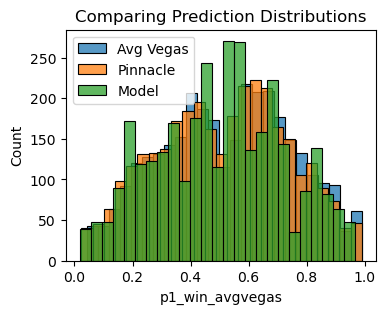

In [9]:
# plotting the distributions of predictions for p1
# win for pinnacle, average vegas, and the model

fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['p1_win_avgvegas'], bins=25, label='Avg Vegas')
sns.histplot(trial['p1_win_pinnacle'], bins=25, label='Pinnacle')
sns.histplot(trial['pred_player_one_win'], bins=25, label='Model')

plt.title("Comparing Prediction Distributions")
plt.legend()
plt.show()

# Comparing Log Loss  

Below I plot the log loss comparisons for the model  
and Pinnacle with different cutoffs. For example,  
when the cutoff is 0.01 it means we're only comparing  
the log loss for matches where the model win probability  
diverged by less than 0.01 from Pinnacle.  

The model is doing very well until about 0.075%.  
When the model diverges by more than that it performs  
relatively poorly. It is worth noticing that Vegas also  
does worse as the divergence increases, suggesting that these  
matches were less predictable.

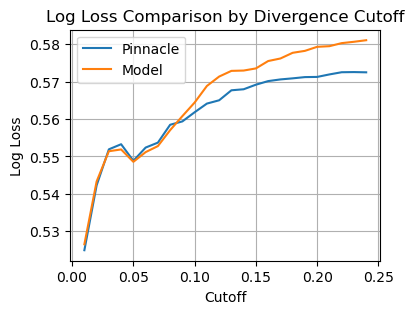

In [16]:
trial['abs_diff'] = abs(trial['p1_win_pinnacle'] - trial['pred_player_one_win'])

increments = np.arange(0.01, 0.25, 0.01)

ll_vegas = []
ll_model = []

for n in increments:
    filtered_ = trial[trial['abs_diff'] <= n]
    ll_vegas_ = log_loss(filtered_['player_one_winner'], filtered_['p1_win_pinnacle'])
    ll_model_ = log_loss(filtered_['player_one_winner'], filtered_['pred_player_one_win'])
    
    ll_vegas.append(ll_vegas_)
    ll_model.append(ll_model_)
    
fig, ax = plt.subplots(figsize=(4,3))

plt.plot(increments, ll_vegas, label='Pinnacle')
plt.plot(increments, ll_model, label='Model')

plt.title("Log Loss Comparison by Divergence Cutoff")
plt.xlabel("Cutoff")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend()
plt.show()

# Kelly Simulation  

Creating a simple simulation of Kelly bets to  
examine how our bankroll would grow with different  
simple rules.

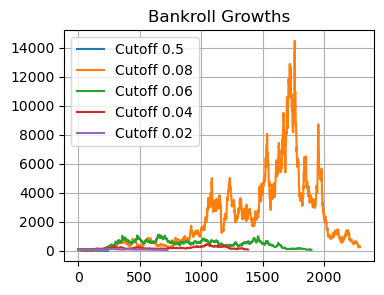

In [29]:
cutoffs = [0.5, 0.08, 0.06, 0.04, 0.02]
bankrolls = []

for c in cutoffs :
    test_ = trial[trial['abs_diff'] <= c].copy()

    bankroll_evolution = []
    bankroll = 100
    bets = 0

    for wkp, lkp, psw in zip(test_['winner_kelly_bet'], test_['loser_kelly_bet'], test_['psw']):

        if wkp > 0:
            bets += 1
            bet_size = bankroll * wkp
            bankroll = bankroll + ((bet_size * psw) - bet_size)

        elif lkp > 0:
            bets + 1
            bet_size = bankroll * lkp
            bankroll = bankroll - bet_size

        if bankroll <= 0.1:
            break
        bankroll_evolution.append(bankroll)
    
    bankrolls.append(bankroll_evolution)
    
fig, ax = plt.subplots(figsize=(4,3))

for b, c in zip(bankrolls, cutoffs):
    plt.plot(pd.Series(b), label=f'Cutoff {c}')

plt.title("Bankroll Growths")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
model_brier = lambda x: brier_score_loss([1] * len(x), x['model_w_pred'])
pinnacle_vegas_brier = lambda x: brier_score_loss([1] * len(x), x['pinnacle_vegas_pred_w'])

briers_df = (
    pd.concat([trial.groupby(['season', 'tourney_name']).apply(model_brier),
               trial.groupby(['season', 'tourney_name']).apply(pinnacle_vegas_brier)], axis=1)
    .rename(columns={0 : 'model', 1 : 'pinnacle'})
    .reset_index()
)

briers_df['model_wins'] = (briers_df['model'] < briers_df['pinnacle']).astype(int)

tourney_surface = trial.groupby('tourney_name')['surface'].first().to_dict()
briers_df['surface'] = [tourney_surface[x] for x in briers_df['tourney_name']]

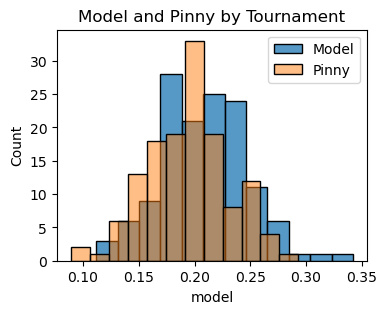

In [15]:
# plotting the performance of the model vs pinny
# across tourneys

fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(briers_df['model'], label='Model')
sns.histplot(briers_df['pinnacle'], label='Pinny', alpha=0.5)

plt.title("Model and Pinny by Tournament")
plt.legend()
plt.show()

# Does a Mixture of Vegas + Model Beat Vegas?  

The answer is yes, as can be seen below. That means  
we're likely on the right track, even if we aren't there yet.  
The model is capturing something useful.  

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

splitter = KFold(n_splits=100, shuffle=True)

oof = np.zeros(len(trial))

X = trial[['p1_win_pinnacle', 'pred_player_one_win']]
y = trial['player_one_winner']

for train, val in splitter.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y.iloc[train]
    
    val_x = X.iloc[val]
    
    model = LinearRegression()
    model.fit(train_x, train_y)
    
    preds = model.predict(val_x)
    oof[val] = preds

print("log loss for vegas only:", log_loss(y, trial['p1_win_pinnacle']))
print("log loss for blend on the out of fold predictions", log_loss(y, oof))

log loss for vegas only: 0.573638860431656
log loss for blend on the out of fold predictions 0.5730280872256893


# Bootstrap Resampling  

Bootstrap resampling to estimate SE of log loss for the Pinnacle  
closing line and the model. Here we sample tourney_ids with  
replacement to account for the intra-tournament correlation in  
error from, for example, weather, court conditions, incentives  
invisible to me (home crowd, favorite tournament, critical career  
juncture, etc.)

In [17]:
# doing bootstrap resampling to estimate the mean and standard
# error of our log loss samples. it's likely that errors are correlated,
# so in each iteration we sample a set of tourney ids to compare.
# the standard error converges to 0.008 for vegas and 0.0083 for model

SAMPLES = 250
vegas_losses = []
model_losses = []

for _ in range(SAMPLES):

    tourneys = trial['tourney_id'].sample(55, replace=True)
    bootstrap_sample = trial[trial['tourney_id'].isin(tourneys)]
    
    vegas_loss = log_loss(bootstrap_sample['player_one_winner'], bootstrap_sample['p1_win_pinnacle'])
    model_loss = log_loss(bootstrap_sample['player_one_winner'], bootstrap_sample['pred_player_one_win'])
    
    vegas_losses.append(vegas_loss)
    model_losses.append(model_loss)

print("vegas mean and std of samples", np.mean(vegas_losses), np.std(vegas_losses, ddof=1))
print("model mean and std of samples", np.mean(model_losses), np.std(model_losses, ddof=1))

vegas mean and std of samples 0.55477639859659 0.007747738686235474
model mean and std of samples 0.5628016356838657 0.007952695450308243


# Large Deviations  

Where did the model deviate the most from the market?  

I might find clues to improve the model in general. 

In [18]:
# calculating diff between market and model
trial['oof_mixture'] = oof
trial['diff_bin'] = pd.qcut(trial['abs_diff'], q=20)

trial['month'] = trial.tourney_date.dt.month
trial['season'] = trial.tourney_date.dt.year

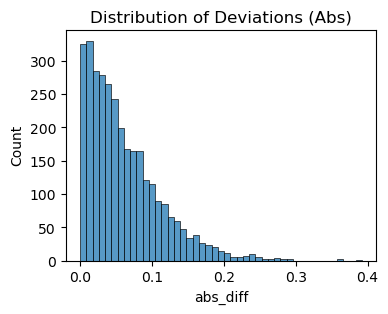

In [19]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(trial['abs_diff'])

plt.title("Distribution of Deviations (Abs)")
plt.show()

In [21]:
month_comparison = (
    pd.concat(
        [trial.groupby('month').apply(lambda x: log_loss(x['player_one_winner'], x['p1_win_pinnacle'])), 
         trial.groupby('month').apply(lambda x: log_loss(x['player_one_winner'], x['pred_player_one_win']))], axis=1)
    .rename(columns={0 : 'vegas', 1 : 'model'})
)

month_comparison['matches'] = trial.groupby('month').size()
month_comparison['vegas_edge'] = month_comparison['model'] - month_comparison['vegas']

month_comparison

,vegas,model,matches,vegas_edge
month,,,,
1,0.585893,0.597111,323,0.011217
2,0.578172,0.595960,414,0.017788
3,0.587170,0.589152,320,0.001981
4,0.603222,0.594272,266,-0.008949
5,0.533511,0.541713,349,0.008203
6,0.545444,0.560475,332,0.015031
7,0.601438,0.618313,254,0.016875
8,0.576683,0.589407,419,0.012723
9,0.578408,0.591635,176,0.013227


<Axes: >

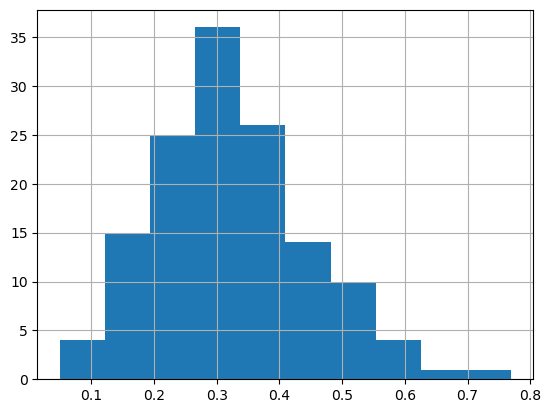

In [22]:
trial.groupby('tourney_id')['abs_diff'].apply(lambda x: len(x[x >= 0.075]) / len(x)).hist()

In [23]:
# almost every single prediction in this tournament deviates
# from the market by a substantial amount

cols = ['winner_name', 'loser_name', 'player_id', 'player_2_id', 'p1_win_pinnacle',
        'pred_player_one_win', 'abs_diff', 'tourney_date', 'tourney_id', 'round', 'tourney_name']


trial[trial['tourney_id'] == '2022-0717'][cols].tail(60)

,winner_name,loser_name,player_id,player_2_id,p1_win_pinnacle,pred_player_one_win,abs_diff,tourney_date,tourney_id,round,round,tourney_name
47692,Michael Mmoh,Sam Querrey,111581.0,105023.0,0.349650,0.331939,0.017711,2022-04-04,2022-0717,4,2nd Round,Houston
47693,Nick Kyrgios,Tommy Paul,126205.0,106401.0,0.429185,0.525038,0.095853,2022-04-04,2022-0717,4,2nd Round,Houston
47694,Reilly Opelka,Mitchell Krueger,124187.0,106283.0,0.719424,0.750594,0.031170,2022-04-04,2022-0717,4,2nd Round,Houston
47695,Gijs Brouwer,J J Wolf,133835.0,200670.0,0.277008,0.439233,0.162225,2022-04-04,2022-0717,4,2nd Round,Houston
47696,Frances Tiafoe,Pablo Cuevas,126207.0,104655.0,0.641026,0.829186,0.188161,2022-04-04,2022-0717,4,2nd Round,Houston
47697,John Isner,Steve Johnson,104545.0,105449.0,0.561798,0.392555,0.169243,2022-04-04,2022-0717,4,2nd Round,Houston
47698,Cristian Garin,Jordan Thompson,111442.0,106426.0,0.324675,0.412698,0.088023,2022-04-04,2022-0717,4,2nd Round,Houston
47699,Taylor Fritz,Alejandro Tabilo,126214.0,126203.0,0.492611,0.402494,0.090117,2022-04-04,2022-0717,4,2nd Round,Houston
47700,Reilly Opelka,Gijs Brouwer,124187.0,133835.0,0.781250,0.856734,0.075484,2022-04-04,2022-0717,5,Quarterfinals,Houston
47701,John Isner,Frances Tiafoe,104545.0,126207.0,0.520833,0.402337,0.118497,2022-04-04,2022-0717,5,Quarterfinals,Houston


In [50]:
trial[trial['tourney_id'] == '2022-0741'][cols].tail(60)

,winner_name,loser_name,player_id,player_2_id,pinnacle_pred,model_pred,abs_diff,tourney_date,tourney_id,round,round,tourney_name
48606,Daniel Evans,Adrian Mannarino,105554.0,105173.0,0.657895,0.634770,0.023125,2022-06-20,2022-0741,3,1st Round,Eastbourne
48613,Thiago Monteiro,Ugo Humbert,200005.0,106329.0,0.239234,0.462926,0.223692,2022-06-20,2022-0741,3,1st Round,Eastbourne
48617,Cameron Norrie,Brandon Nakashima,111815.0,206909.0,0.609756,0.456247,0.128815,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48618,Maxime Cressy,Daniel Evans,202195.0,105554.0,0.395257,0.388075,0.017006,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48619,Jack Draper,Diego Schwartzman,207733.0,106043.0,0.336700,0.550188,0.239843,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48620,Ryan Peniston,Pedro Martinez,124079.0,126106.0,0.704225,0.312829,0.365628,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48621,Alexander Bublik,John Millman,122330.0,105357.0,0.662252,0.654291,0.017927,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48622,Taylor Fritz,Thiago Monteiro,126203.0,106329.0,0.740741,0.666972,0.073769,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48624,Tommy Paul,Jannik Sinner,206173.0,126205.0,0.446429,0.484637,0.062672,2022-06-20,2022-0741,4,2nd Round,Eastbourne
48626,Jack Draper,Ryan Peniston,207733.0,126106.0,0.310559,0.281885,0.001309,2022-06-20,2022-0741,5,Quarterfinals,Eastbourne
